本实验用于使用优化器为SAGA的分类实验

依赖与全局设置

In [1]:
# Cell 1 — 基础依赖和随机种子配置

import numpy as np                        # 数值计算核心库
import matplotlib.pyplot as plt           # 可视化
from sklearn.datasets import make_classification  # 生成合成数据
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,                       # 准确率
    confusion_matrix, ConfusionMatrixDisplay,  # 混淆矩阵
    roc_curve, auc                        # ROC 曲线与 AUC 计算
)

# 固定随机种子，保证每次运行结果一致
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Dependencies loaded. Random seed set to", RANDOM_STATE)


Dependencies loaded. Random seed set to 42


生成一个二维二分类数据集，并可视化其分布

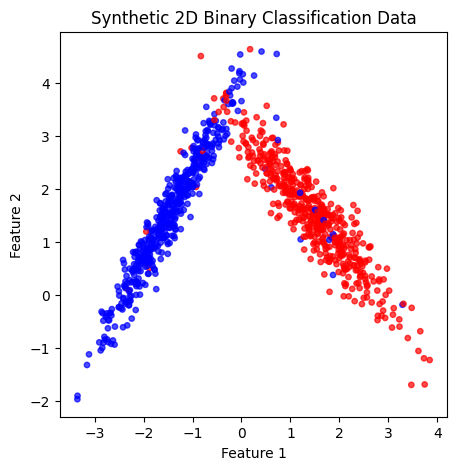

In [2]:
# Cell 2 — 生成一个二维二分类数据集，并可视化其分布

# 使用 scikit-learn 生成 1000 个样本，2 个特征，5% 标签噪声
X, y = make_classification(
    n_samples=1000,       # 样本总数
    n_features=2,         # 特征维度
    n_informative=2,      # 有信息特征数
    n_redundant=0,        # 冗余特征数
    n_clusters_per_class=1,
    flip_y=0.05,          # 标签噪声比例
    class_sep=1.5,        # 类别分离度
    random_state=RANDOM_STATE
)

# 简单散点图
plt.figure(figsize=(5,5))
plt.scatter(
    X[:, 0], X[:, 1],    # 横纵坐标
    c=y,                 # 按标签上色
    cmap='bwr',          # 双色图：蓝/红
    s=15,                # 点大小
    alpha=0.7            # 透明度
)
plt.title("Synthetic 2D Binary Classification Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


Cell 3 — 划分训练集与测试集

In [4]:
# Cell 3 — 将数据划分为训练集和测试集（70/30 划分）

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,             # 30% 用作测试
    stratify=y,                # 分层抽样，保持类别比例
    random_state=RANDOM_STATE
)

print(f"Training samples: {len(y_train)}, Testing samples: {len(y_test)}")


Training samples: 700, Testing samples: 300


纯 NumPy 实现 Multinomial SAGA 分类器

In [5]:
# Cell 4 — 手写 SAGA 算法的核心实现，并附超详细注释

class SAGAClassifier:
    """
    多类 Logistic 回归（softmax）+ SAGA 优化算法。
    - 支持 L2 正则化（ridge）
    - 可选 L1 正则化（lasso） via 软阈值（proximal）操作
    """

    def __init__(self, n_features, n_classes,
                 lr=1e-2, l2=0.0, l1=0.0):
        """
        参数：
          n_features: 特征数 d
          n_classes:  类别数 C
          lr:         学习率（step size）
          l2:         L2 正则强度 λ2
          l1:         L1 正则强度 λ1
        """
        # 初始化模型参数：全零矩阵/向量
        self.W = np.zeros((n_classes, n_features))  # 权重矩阵 [C × d]
        self.b = np.zeros(n_classes)                # 偏置向量 [C]

        # 学习率和正则化系数
        self.lr, self.l2, self.l1 = lr, l2, l1

        # 用于存储每个样本的“历史梯度”，形状 [N × C × (d+1)]
        # 最后一维多 +1 来放偏置梯度
        self.grad_table = None
        self.N = None  # 样本总数 N

    def _softmax(self, Z):
        """
        给定 Z 形状 [batch × C]，返回 softmax 后的概率 [batch × C]。
        为了数值稳定性，先减去每行的最大值。
        """
        # Z_max shape = [batch × 1]
        Z_max = np.max(Z, axis=1, keepdims=True)
        expZ = np.exp(Z - Z_max)
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def _onehot(self, y, C):
        """
        将标签 y (长度 b) 转成 one-hot 编码 [b × C]。
        """
        b = len(y)
        oh = np.zeros((b, C))
        oh[np.arange(b), y] = 1
        return oh

    def fit(self, X, y, X_val=None, y_val=None,
            batch_size=64, epochs=20):
        """
        在训练集 (X, y) 上运行 SAGA，迭代 epochs 轮；
        若提供验证集 (X_val, y_val)，每轮同时计算验证准确率。

        返回：
          history: np.array shape [epochs × 2]，
                   每行 = [train_acc, val_acc]
        """
        N, d = X.shape        # 样本数 N、特征数 d
        C = self.W.shape[0]   # 类别数 C
        self.N = N

        # 初始化梯度表为全零
        # 每条记录 shape = [C × (d+1)]，最后 1 列对应偏置
        self.grad_table = np.zeros((N, C, d + 1))

        history = []  # 存放每轮的 [train_acc, val_acc]

        # 主循环：epochs 轮
        for epoch in range(1, epochs + 1):
            # 每轮都打乱样本索引，保证随机抽样
            perm = np.random.permutation(N)

            # 按 batch_size 切分 minibatch
            for start in range(0, N, batch_size):
                idx = perm[start : start + batch_size]  # 当前 batch 的索引
                Xb = X[idx]     # [b × d]
                yb = y[idx]     # [b]

                # 1) 计算当前模型对 batch 的预测概率
                Zb = Xb.dot(self.W.T) + self.b   # [b × C] 线性输出
                Pb = self._softmax(Zb)           # [b × C] 概率分布

                # 2) 计算交叉熵梯度：grad = P - Y_onehot 形状 [b × C]
                Yoh = self._onehot(yb, C)        # [b × C]
                grad = Pb - Yoh                  # [b × C]

                # 3) 计算“每样本”的完整梯度 g_full shape [b × C × (d+1)]
                #    - 对 W 的梯度 g_w = grad[:, :, None] * Xb[:, None, :]
                #    - 对 b 的梯度 g_b = grad (broadcast 到最后一维)
                g_w = grad[:, :, None] * Xb[:, None, :]      # [b × C × d]
                g_b = grad[:, :, None]                       # [b × C × 1]
                g_full = np.concatenate([g_w, g_b], axis=2)  # [b × C × (d+1)]

                # 4) SAGA 方差消除核心
                #    - 从新梯度减去旧梯度表：g_full - grad_table[idx]
                #    - 平均：mean over batch
                #    - 加上全表平均：grad_table.mean(axis=0)
                g_diff = g_full - self.grad_table[idx]        # [b × C × (d+1)]
                g_est  = g_diff.mean(axis=0) + self.grad_table.mean(axis=0)
                #    此时 g_est shape = [C × (d+1)]，是“无偏低方差”的梯度估计

                # 5) 参数更新：先更新 W,b 的梯度下降（含 L2 正则）
                #    W ← W - lr*(g_W + l2*W)
                #    b ← b - lr*(g_b)
                self.W -= self.lr * (g_est[:, :d] + self.l2 * self.W)
                self.b -= self.lr *  g_est[:, d]

                # 6) L1 正则的 proximal 步骤（软阈值），若 l1>0
                if self.l1 > 0:
                    # W_ij = sign(W_ij) * max(|W_ij| - lr*l1, 0)
                    self.W = np.sign(self.W) * \
                             np.maximum(np.abs(self.W) - self.lr * self.l1, 0.0)

                # 7) 更新梯度表中该 batch 的条目
                self.grad_table[idx] = g_full

            # --- 每轮结束后计算准确率 ---
            train_acc = self.score(X, y)
            val_acc = None
            if X_val is not None:
                val_acc = self.score(X_val, y_val)
                history.append((train_acc, val_acc))
                print(f"Epoch {epoch:02d} — train_acc: {train_acc:.3%}, val_acc: {val_acc:.3%}")
            else:
                history.append((train_acc, ))
                print(f"Epoch {epoch:02d} — train_acc: {train_acc:.3%}")

        return np.array(history)

    def predict_proba(self, X):
        """返回给定 X 的预测概率 [n_samples × C]"""
        Z = X.dot(self.W.T) + self.b
        return self._softmax(Z)

    def predict(self, X):
        """返回给定 X 的预测类别 [n_samples]"""
        return self.predict_proba(X).argmax(axis=1)

    def score(self, X, y):
        """计算预测准确率"""
        return np.mean(self.predict(X) == y)


训练 SAGA 分类器 & 曲线可视化

Epoch 01 — train_acc: 95.893%, val_acc: 95.000%
Epoch 02 — train_acc: 95.893%, val_acc: 95.000%
Epoch 03 — train_acc: 96.071%, val_acc: 95.000%
Epoch 04 — train_acc: 96.071%, val_acc: 95.000%
Epoch 05 — train_acc: 96.071%, val_acc: 95.000%
Epoch 06 — train_acc: 96.071%, val_acc: 95.000%
Epoch 07 — train_acc: 96.071%, val_acc: 95.000%
Epoch 08 — train_acc: 96.071%, val_acc: 95.000%
Epoch 09 — train_acc: 96.071%, val_acc: 95.000%
Epoch 10 — train_acc: 96.071%, val_acc: 95.000%
Epoch 11 — train_acc: 95.893%, val_acc: 95.000%
Epoch 12 — train_acc: 95.893%, val_acc: 95.000%
Epoch 13 — train_acc: 95.893%, val_acc: 95.000%
Epoch 14 — train_acc: 95.893%, val_acc: 95.000%
Epoch 15 — train_acc: 95.893%, val_acc: 95.000%
Epoch 16 — train_acc: 95.893%, val_acc: 95.000%
Epoch 17 — train_acc: 95.893%, val_acc: 95.000%
Epoch 18 — train_acc: 95.893%, val_acc: 95.000%
Epoch 19 — train_acc: 95.893%, val_acc: 95.000%
Epoch 20 — train_acc: 95.893%, val_acc: 95.000%
Epoch 21 — train_acc: 95.893%, val_acc: 

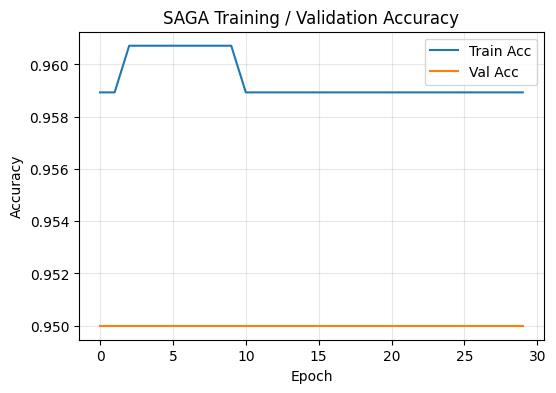

In [6]:
# Cell 5 — 训练并绘制训练/验证准确率曲线

# 划分训练/验证集（留 20% 做简单验证）
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train
)

# 实例化 SAGA 分类器
saga = SAGAClassifier(
    n_features=2,         # 我们的数据是 2D
    n_classes=2,          # 二分类
    lr=1e-2,              # 学习率
    l2=1e-4,              # L2 正则
    l1=0.0                # 不用 L1
)

# 训练，记录 train/val 准确率
history = saga.fit(
    X_tr, y_tr,
    X_val, y_val,
    batch_size=64,
    epochs=30
)

# 绘制准确率曲线
plt.figure(figsize=(6,4))
plt.plot(history[:,0], label="Train Acc")
plt.plot(history[:,1], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("SAGA Training / Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


测试评估：混淆矩阵 & ROC 曲线

Test Accuracy: 94.667%


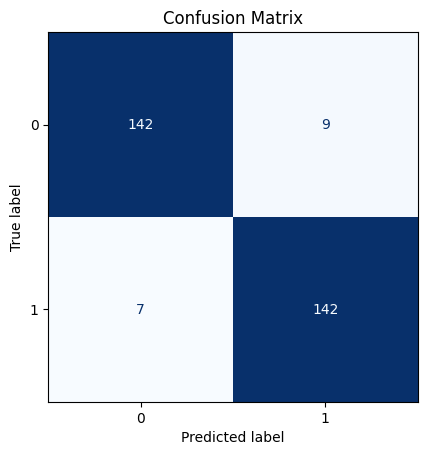

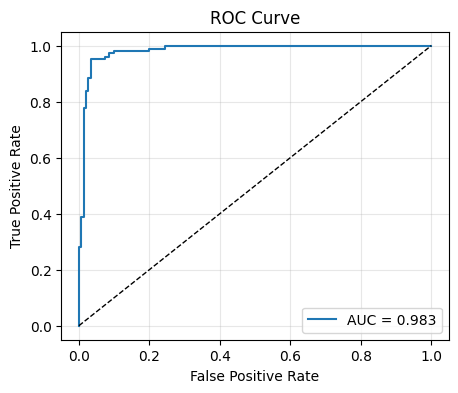

In [7]:
# Cell 6 — 在测试集上评估并可视化

# 1) 预测与准确率
y_pred = saga.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.3%}")

# 2) 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.show()

# 3) ROC 曲线 & AUC
y_prob = saga.predict_proba(X_test)[:,1]  # 取正类概率
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"k--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
